In [1]:
from utils.ML1.utils import *
from utils import plotcfg
from tqdm.notebook import tqdm

# 5. Machine Learning based approach for a single joint
As seen in the last [chapter](./4.0_Analytical_Method.ipynb), there are nonlinearities in the residuals, potentially arising
from dynamic coupling and inaccuracies in modelling. These challenges cannot be fully
addressed through analytical methods alone and necessitate a more statistical approach.
[Section 2.3](./2.0_State_of_the_art.ipynb#2.3.-Machine-Leanring-Based-Approaches) summarized some studies which demonstrated the effectiveness of machine
learning (ML) in learning these residuals or modelling complex physical phenomena. Additionally, ML methods have the potential to learn the dynamic coupling characteristics <cite id="hicib"><a href="#zotero%7C17740253%2F2JIYDKKU">[1]</a></cite> statistically based on experimental data, hence it is not limited to simplifying
assumptions or modelling errors which can happen in the case of analytical methods.

In this chapter, the approach is to utilize torque information from both encoders and
motor currents, along with other relevant inputs such as joint velocity and torque feedforward to train four different model architectures. Since the ML model requires a target
value for learning, and given the potential inaccuracies in the encoder and current values, a
Bota SenseONE force/torque sensor (FTS) was attached to the Tool Center Point (TCP),
providing six output measurements ($F_x$, $F_y$, $F_z$ , $\tau_x$, $\tau_y$, $\tau_z$ ). These TCP wrench measurements can be projected into the joint space using appropriate equations, thereby offering
accurate external torque estimations. While FTS sensors have known issues, such as
temperature drift <cite id="smjd8"><a href="#zotero%7C17740253%2FSQ92H4YE">[2]</a></cite>, this study assumes the external joint torque derived from the
FTS readings to be accurate. Four potential ML model architectures are chosen based
on their ability to learn temporal patterns and relations in data. In the end the results
from these four models are compared and the performance of the best one is evaluated
against the baseline method. Similar to previous chapters, this analysis focuses on a single
joint (Joint-3) of the LARA8 for simplicity and to establish a baseline comparison before
extending the modelling to all the joints.

## 5.1. Data Collection
The robot was mounted vertically, with its base securely attached to a horizontal plane
as shown in <a href="#centric_tool">Figure 5.1</a>. Joint-3 was rotated at a constant speed, sweeping from $-150°$
to $150°$. Additionally, external loads were mounted between measurements, with weights
randomly selected from 0 kg, 1.225 kg, 2.225 kg, 3.225 kg, 5.225 kg, 7.225 kg, and 9.225
kg. For each load condition, 20 different joint velocities were drawn from a uniform
distribution ranging between $0.01 rad/s$ and $1.15 rad/s$. Each measurement involved a
single to-and-fro motion between the joint limits.
<figure style="text-align: center;">
    <img src="./Resources/lara8.jpg" id="centric_tool" style="width:30%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.1.: </b>LARA8 with centric load mounted on TCP </figcaption>
</figure>


During data collection, FTS readings (in TCP coordinate frame), joint velocity, joint
angle, torque feedforward, motor torque, load-side encoder counts, and motor-side encoder
counts were recorded. These measurements were taken at a sampling frequency of 500 Hz,
equating to a sampling time of 2 millisecond. This high-resolution data acquisition was
essential for capturing detailed and accurate information. Maintaining a 2-millisecond
sampling time was crucial to meet real-time processing requirements <cite id="10r6g"><a href="#zotero%7C17740253%2FSCKUII9T">[3]</a></cite>.

One of the measurements was kept aside for validation and was hence not used in training.

In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("ML1")

downloading data:   0%|          | 0/41794 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


## 5.2. Target Selection

The FTS sensor provides 6 readings namely $F_x, F_y, F_z, \tau_x, \tau_y,\tau_z$, since only Joint-3 is under study and is actuated, not all components of the wrench can be estimated from Joint-3. The relation between Wrench (${}^{TCP}W_{ext}$) and joint torque ($\tau_3$) is given by
$$
\tau_3 = {}^{TCP}J_3^T.{}^{TCP}W_{ext},\tag{5.1}
$$
a close examination of the Jacobain ${}^{TCP}J_3^T$ reveals that components of $W_{ext}$ which produce a torque in Joint-3 are $F_x, F_z$ and $\tau_y$. The derivation is provided in [Appendix](./Appendix.ipynb).

## 5.3. Inputs and Data Preprocessing
The inputs used for analytical methods and motor-current-based approach are used here,
namely joint velocity, motor current, torque feedforward, motor side and load side encoder
measurements. These provide the necessary information for the model to estimate external
joint torques. Joint angles, although an important component for gravity-based torque
are not included because this information is already present in the load side encoder
measurements. In addition to this, the use of encoder difference [Equation 3.3](./3.0_Fundamentals.ipynb#Stiffness-of-Harmonic-Drive-Transmission) has also
showed improvement in the results

Each of the seven input and three targets were min-max scaled using Equation 5.2, to lie in
the range of -1 to 1 which has been proven to benefit the model training <cite id="e2jlh"><a href="#zotero%7C17740253%2FYV6H62JS">[4]</a></cite>. This
range is usually preferred when the activation function of the model is $tanh$.

\begin{equation}
Y' = \frac{(Y - Y_{\text{min}})}{(Y_{\text{max}} - Y_{\text{min}})} \times 2 - 1\tag{5.2}
\end{equation}

Where:
* $Y'$ is the scaled value.
* $Y$ is the original value.
* $Y_{\text{min}}$ is the minimum value in the original data.
* $Y_{\text{max}}$ is the maximum value in the original data.

The max and min values are saved for later inference to rescale the predictions to their original scale.

## 5.4. Model Architecture

The model has seven inputs and three outputs. The model must be sufficiently large to
accurately capture the physical mapping from inputs to outputs without overfitting, yet
compact enough to be deployed on a robot equipped with an Intel® Core™ i5-10210U
Processor, 16GB of RAM, and no GPU. It should achieve inference times under 2 milliseconds to meet real-time performance requirements. Given that the model needs to learn nonlinearities, such as hysteresis, which depend on the previous states of the joint, a recurrent neural network architecture is an ideal candidate. Hence, recurrent architectures
like RNNs, GRUs, and LSTMs and a Fully connected neural network (FCN) are trained
and their results compared. One example model definition is provided in the code cell below
for reference. The model below consists of stacked GRUs followed by a fully connected
neural network. The Tanh activation function is chosen for its ability to achieve higher
nonlinearity in a smaller network, even though ReLU, while simpler and computationally
efficient, would require a larger network to achieve similar results <cite id="c0xpt"><a href="#zotero%7C17740253%2FUQXRRX7F">[5]</a></cite>. A visualization
of the four model architectures chosen for the study is shown in Figure 5.2.

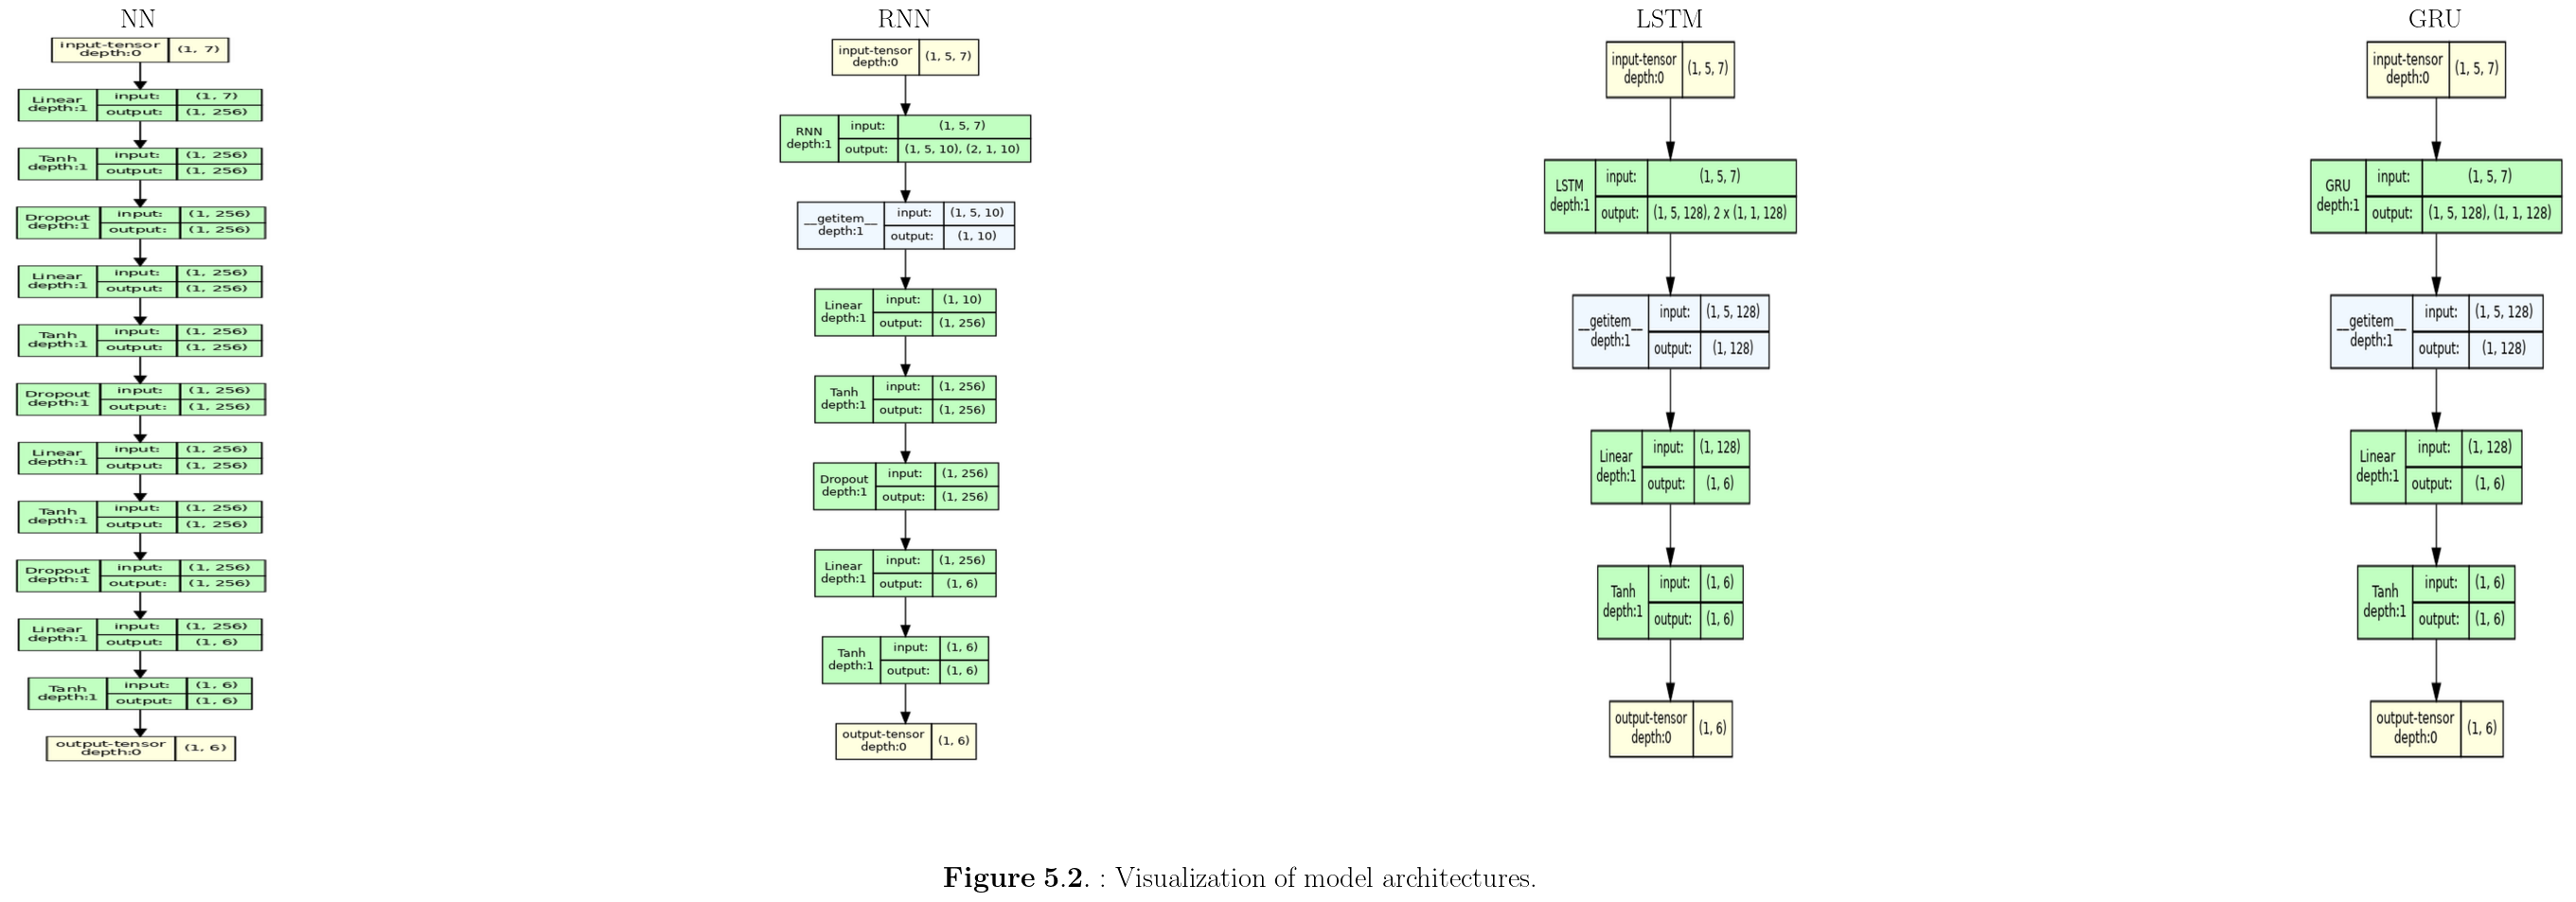

In [3]:
from utils.ML1.model_defenitions import NN, RNN, LSTM
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        out, _ = self.gru(x)  
        out = out[:, -1, :]
        out = self.activation(self.fc(out))
        return out
visualize_models()

## 5.5. Training
The hyperparameters, including learning rate, number of epochs, batch size, hidden size,
and number of layers, were optimized through grid search. However, to ensure a fair
comparison among the three recurrent models, the sequence length was kept constant.
The pre-processed data was segmented into sequences, shuffled, and then split into two
distinct datasets: 75% was designated for training, while the remaining 25% for testing.
This split allows the test dataset, which was not used during training, to serve as a
validation set, enabling the detection of overfitting. Overfitting is identified when the
validation loss begins to increase while the training loss continues to decrease.

In [4]:
#Hyperparameters
learning_rate = 0.0002
EPOCHS = 5
BATCH_SIZE = 2048
sequence_length = 5# length of each input sequence
hidden_size = 128 # number of hidden states of GRU
num_layers = 1 # number of GRU stacked one after the other
input_size = 7 # number of input features 
output_size = 6 # number of output (6 fts readings)

dataset = CustomDatasetFromCSV(csv_path = '/mnt/data/ML1/data.csv',sequence_length=sequence_length,mode="train")

train_length = int(0.75* len(dataset))
test_length = len(dataset)-train_length
train_dataset,test_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))

The optimizer used is Adam <cite id="dkdov"><a href="#zotero%7C17740253%2F3HI9B7Q7">[6]</a></cite> which is a type of stochastic gradient descent technique. According to **Kingma et al., 2014**, Adam optimizer is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".


The loss function used to train the machine learning model is the Mean Squared Error (MSE), which quantifies the difference between the predicted joint torques and the actual torques. The MSE is defined as:

$$
MSE = \sum_{i=1}^{N}(y_i-{y_{pred}}_i)^2
\tag{5.3}
$$

where $y_i $ represents the actual wrench, $ {y_{pred}} $ is the model's predicted wrench based on the joint's position and $n$ is the total number of samples. The training process involves iteratively updating the model's weights to minimize the loss. The process is conducted over multiple epochs, where each epoch consists of a complete pass through the training data. At the beginning of each epoch, the training data is loaded in batches. For each batch, the following steps are performed:

* Forward Propagation: The input sequence $X$ is passed through the model to generate the predicted output $y_{\text{pred}}$. The loss is then computed using Equation 5.3

* Backpropagation: The gradients of the loss with respect to the model's weights are calculated through backpropagation. 

* Optimization: The optimizer, Adam, is used to adjust the model's weights based on the computed gradients. This step aims to minimize the loss function, thereby improving the model's predictions over time.

The process is repeated for the set number of epochs, with each epoch contributing to the gradual reduction of the loss. The code used for training GRU model is provided for reference, however,  pre-trained models will be loaded in the code cell below and used throughout the chapter.

In [5]:
import os

file_path = "utils/ML1/models/GRU_model.pt"
if os.path.exists(file_path):
    print("using pre-trained model")
    nn_model = torch.jit.load('utils/ML1/models/NN_model.pt', map_location=torch.device('cpu'))
    rnn_model = torch.jit.load('utils/ML1/models/RNN_model.pt', map_location=torch.device('cpu'))
    gru_model = torch.jit.load('utils/ML1/models/GRU_model.pt', map_location=torch.device('cpu'))
    lstm_model = torch.jit.load('utils/ML1/models/LSTM_model.pt', map_location=torch.device('cpu'))
else:
    model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    # Train the model
    n_total_steps = len(train_dataloader)
    for epoch in range(EPOCHS):
        for i, (X, y) in enumerate(progress_bar): 
            #Forward propagation
            y_pred = model(X)
            loss = criterion(y_pred, y)
            # Backpropagation and optimize
            model.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

using pre-trained model


## 5.6. Resuts

An inference is done on all the models and the predictions are rescaled to their original
scale. The Figures <a href="#predictions">5.3</a>, <a href="#predictions">5.4</a>, <a href="#predictions">5.5</a>, <a href="#predictions">5.6</a> below shows the prediction of all four trained models.

In [6]:
# To denormalize the predictions
y_max = torch.load('utils/ML1/fts_GRU/models/y_max.pt', map_location=torch.device('cpu'))
y_min = torch.load('utils/ML1/fts_GRU/models/y_min.pt', map_location=torch.device('cpu'))

dataset = CustomDatasetFromCSV(csv_path='utils/ML1/fts_GRU/data/validate.csv', sequence_length=sequence_length, device="cpu", mode="test")
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model = torch.jit.load('utils/ML1/fts_GRU/models/model.pt', map_location=torch.device('cpu'))
model.eval()

pred_list = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(test_dataloader)):
        pred = model(X)
        pred = (pred + 1) / 2 * (y_max - y_min) + y_min
        pred_list.append(pred)

# Denormalize the data
y_truth = ((test_dataloader.dataset.y + 1) / 2 * (y_max - y_min) + y_min).cpu().numpy()
pred_list = torch.cat(pred_list).cpu().numpy()

  0%|          | 0/1827 [00:00<?, ?it/s]

###### predictions
<a id="gru"></a>
<figure style="text-align: center;">
    <img src="./utils/ML1/fts_GRU/plots/test.png" id="gru" style="width:100%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.3.: </b> Predictions of GRU model </figcaption>
</figure>

<figure style="text-align: center;">
    <img src="./utils/ML1/fts_RNN/plots/test.png" id="rnn" style="width:100%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.4.: </b> Predictions of RNN model </figcaption>
</figure>

<figure style="text-align: center;">
    <img src="./utils/ML1/fts_LSTM/plots/test.png" id="LSTM" style="width:100%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.5.: </b> Predictions of LSTM model </figcaption>
</figure>

<figure style="text-align: center;">
    <img src="./utils/ML1/fts_NN/plots/test.png" id="FCN" style="width:100%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.6.: </b> Predictions of FCN model </figcaption>
</figure>

The predictions of the ML models are plotted in orange and the reference from the FTS
which is assumed to be the truth here, is plotted in blue. The RMS errors of the predictions
are given in the table below. Out of the four models, it can be seen from the plots and also
in <a href="#rms-errors-table">Table 5.1</a> that FCN and GRU architecture performs well. Since the prediction involves
accounting for hysteresis which is dependent on the history of the trajectory, a recurrent
architecture like GRU is the best choice. The predictions of the FCN network are noisy,
this could have been due to overfitting because the network was too simple and since
the training parameters were same for all models, FCN could have learned the noise in
the training data. While these results may vary with further optimization of each model
and corresponding training parameters, the current findings highlight the effectiveness of
GRU in this application, makes it a strong candidate for modeling across all joints. A
detailed hyperparameter optimization will be conducted in the next chapter.

<table id="rms-errors-table" border="1" style="border-collapse: collapse; text-align: center; width: 50%;">
  <thead>
    <tr>
      <th>Model</th>
      <th>Fx RMS Error</th>
      <th>Fz RMS Error</th>
      <th>Ty RMS Error</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>GRU</td>
      <td>2.8946</td>
      <td>5.0311</td>
      <td>0.0755</td>
    </tr>
    <tr>
      <td>RNN</td>
      <td>23.6302</td>
      <td>23.5079</td>
      <td>0.8505</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>8.9699</td>
      <td>4.5014</td>
      <td>0.3139</td>
    </tr>
    <tr>
      <td>FCN</td>
      <td>2.8823</td>
      <td>4.1089</td>
      <td>0.1265</td>
    </tr>
  </tbody>
  <tfoot>
    <tr>
      <td colspan="4" style="text-align: center;"><b>Table 5.1:</b> RMS Errors for Different Models</td>
    </tr>
  </tfoot>
</table>





## 5.7. Comparison with baseline approach

A comparison is done to evaluate how well the GRU model performs in comparison to
motor-current-based method which is calculated as the difference between motor torque and
torque feedforward, which can be seen in [Figure 5.7](#5.7.-Comparison-with-baseline-approach). The predictions of the ML model
are converted to joint torque using [Equation 5.1](#5.2.-Target-Selection).

<figure style="text-align: center;">
    <img src="./Resources/comparison.png" id="FCN" style="width:80%; margin: auto;">
    <figcaption align="center"> <b>Figure 5.7.: </b> Comparison of joint torque estimates of joint 3. </figcaption>
</figure>

In [Figure 5.7](#5.7.-Comparison-with-baseline-approach), the motor current-based estimation is plotted in orange, the reference
is plotted in green and the prediction of the ML model is plotted in blue. From the plot,
it is clear that the ML model predictions closely match the projected FTS measurements.
The RMS error between the motor current-based method and the FTS readings is *6.4830
Nm* and the RMS error between the ML model and FTS readings is *2.6706 Nm* which shows
a significant improvement of **58.8%**.

However, the same limitation seen in [Section 4.5](./4.0_Analytical_Method.ipynb#4.5.-External-Torque ) applies here as well, since this is also
a single joint model. This motivates the next chapter, where this GRU architecture is
trained on inputs from all joints. This is hypothesised to provide enough information to
capture the dynamic coupling which is the reason for the limitation.

## Bibliography
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|17740253/2JIYDKKU"></i>
    <div class="csl-left-margin">[1]</div><div class="csl-right-inline">K. Xia, L. Ding, G. Liu, H. Gao, and Z. Deng, “A Novel Virtual Torque Sensor for Rescue Robots with Harmonic Drives.” Sep. 23, 2016. doi: <a href="https://doi.org/10.20944/preprints201609.0084.v1">10.20944/preprints201609.0084.v1</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/SQ92H4YE"></i>
    <div class="csl-left-margin">[2]</div><div class="csl-right-inline">F. J. A. Chavez, “Force-Torque Sensing in Robotics.”</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/SCKUII9T"></i>
    <div class="csl-left-margin">[3]</div><div class="csl-right-inline">J. P. Erickson and J. H. Anderson, “Soft Real-Time Scheduling,” in <i>Handbook of Real-Time Computing</i>, Y.-C. Tian and D. C. Levy, Eds. Singapore: Springer Nature Singapore, 2022, pp. 233–267. doi: <a href="https://doi.org/10.1007/978-981-287-251-7_4">10.1007/978-981-287-251-7_4</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/YV6H62JS"></i>
    <div class="csl-left-margin">[4]</div><div class="csl-right-inline">K. Cabello-Solorzano, I. Ortigosa de Araujo, M. Peña, L. Correia, and A. J. Tallón-Ballesteros, “The Impact of Data Normalization on the Accuracy of Machine Learning Algorithms: A Comparative Analysis,” in <i>18th International Conference on Soft Computing Models in Industrial and Environmental Applications (SOCO 2023)</i>, Cham, 2023, pp. 344–353. doi: <a href="https://doi.org/10.1007/978-3-031-42536-3_33">10.1007/978-3-031-42536-3_33</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/UQXRRX7F"></i>
    <div class="csl-left-margin">[5]</div><div class="csl-right-inline">Y. LeCun, Y. Bengio, and G. Hinton, “Deep learning,” <i>Nature</i>, vol. 521, no. 7553, pp. 436–444, May 2015, doi: <a href="https://doi.org/10.1038/nature14539">10.1038/nature14539</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/3HI9B7Q7"></i>
    <div class="csl-left-margin">[6]</div><div class="csl-right-inline">D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization.” arXiv, Jan. 29, 2017. Accessed: Jul. 03, 2024. [Online]. Available: <a href="http://arxiv.org/abs/1412.6980">http://arxiv.org/abs/1412.6980</a></div>
  </div>
</div>
<!-- BIBLIOGRAPHY END -->